# SDA Final Project Submission

**Dataset used:**  Kaggle - [Stroke Prediction Dataset](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)

### **Team Members**



1. Ashish.M
2. Udeep Chandra

### Data Description:
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset containing 5110 data points is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each attribute in the data provides relavant information about the patient.

### Attribute Information:

1) id: unique identifier

2) gender: "Male", "Female" or "Other"

3) age: age of the patient

4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) ever_married: "No" or "Yes"

7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) Residence_type: "Rural" or "Urban"

9) avg_glucose_level: average glucose level in blood

10) bmi: body mass index

11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12) stroke: 1 if the patient had a stroke or 0 if not.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats.distributions as dist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate,GridSearchCV
from sklearn.metrics import confusion_matrix,mean_absolute_error,mean_squared_error,\
r2_score,accuracy_score,precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
import imblearn.pipeline
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv("stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.shape

(5110, 12)

In [ ]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


### Handling NaN values in the data

In this case, we removed all rows with NaN values as attribute values. Because of the large number of available data points, this approach is preferred over replacing with central tendancy satistic.

In [ ]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
df.dropna(axis = 0,inplace = True)
print(df.shape)

(4909, 12)


### Handling categorical data

For all attributes must be numerical, we must encode the categorical attributes in the data before fitting a classifier.

In [ ]:
print("Attributes having categorical data: ")
df.dtypes[df.dtypes == np.object]

Attributes having categorical data: 


gender            object
ever_married      object
work_type         object
Residence_type    object
smoking_status    object
dtype: object

In [ ]:
# Printing the unique values of each categorical attributes
object_cols = ["gender","ever_married","work_type","Residence_type","smoking_status"]

print("Unique values of each categorical attributes: \n")
for col in object_cols:
    print(f"{col} : {df[col].unique()}")

Unique values of each categorical attributes: 

gender : ['Male' 'Female' 'Other']
ever_married : ['Yes' 'No']
work_type : ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type : ['Urban' 'Rural']
smoking_status : ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [ ]:
# Label Encoding the categorical variables
label_encoder = LabelEncoder()

for col in object_cols:
    label_encoder.fit(df[col])
    df[col] = label_encoder.transform(df[col])

In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1
5,56669,1,81.0,0,0,1,2,1,186.21,29.0,1,1


### Analysing target values

In [ ]:
df['stroke'].value_counts()

0    4700
1     209
Name: stroke, dtype: int64

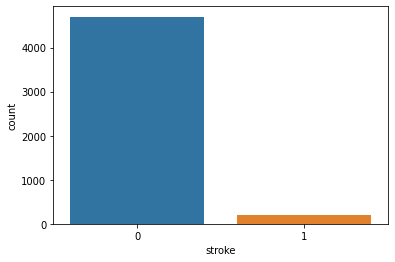

In [ ]:
sns.countplot(x = "stroke", data = df)

In general, imbalanced datasets are skewed against the majority class of the target variable. In this case, the majority class consists of non-stroke patients, while the minority class consists of stroke patients. As a result, if we do not balance these two classes, machine learning algorithms would prioritize the majority class. As a result, it is critical to balance the classes present in target variables.

**Observations:**

* The number of people who have a heart attack is generally negligible as opposed to those who do not.
* The data is extremely unbalanced.
* As a result, when modelling and training data, either over or under sampling must be performed to produce the best results.

### Questions to be answered in the EDA section below: 

* Does age has impact on strokes and how is this parameter distributed?
* Does body mass index and glucose levels in a person, propel a heart stroke?
* Is there a difference in the rate of heart stroke for smokers and non smokers?
* Does the type of job, whether stressful or not, contribute to heart stroke and how it distributes across gender ?
* Are there any significant correaltions between the attributes of the data and how it affects the target variable "stroke" ?

### Explanatory Data Analysis

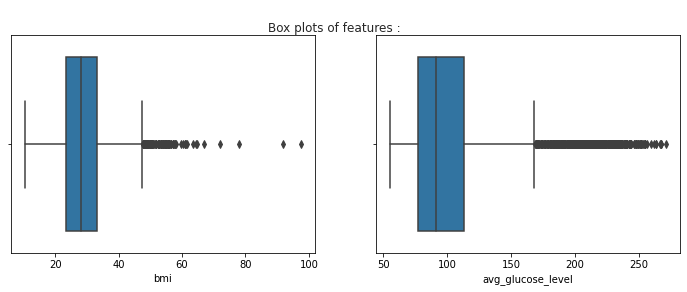

In [ ]:
ny, nx = 1,2
count = 0
features = ['bmi','avg_glucose_level']

fig,axes = plt.subplots(ny,nx,figsize = (12,4))
sns.set_style('darkgrid')
fig.suptitle("\nBox plots of features :")

for i in range(ny):
    for j in range(nx):
        sns.boxplot(ax = axes[j], data = df, x = features[count])
        count += 1

#plt.tight_layout()
plt.subplots_adjust(hspace = 0.1)
plt.show()

**Observation :**

* avg_glucose_level and bmi has large number of outliers present in the dataset.


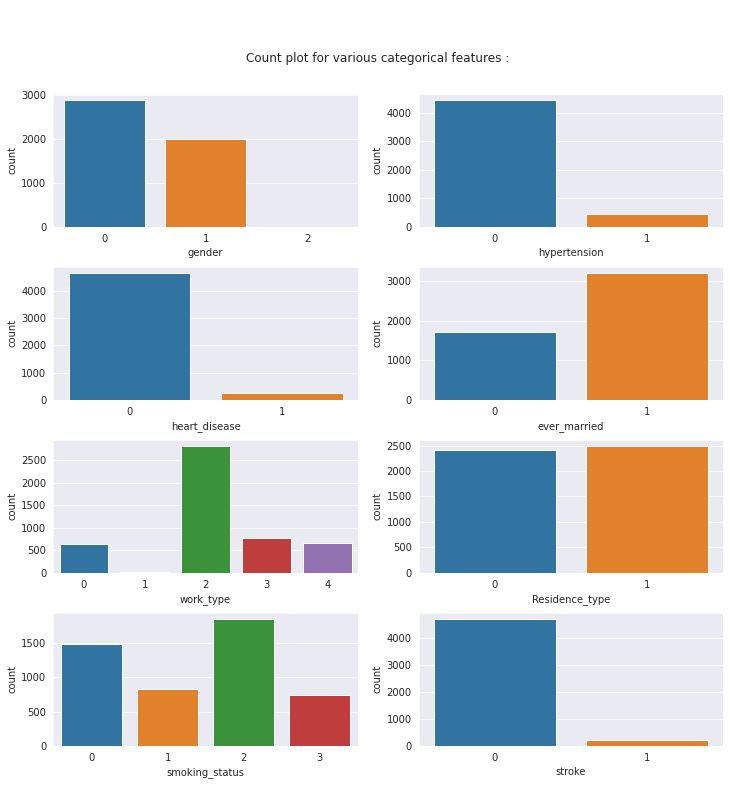

In [ ]:
ny, nx = 4,2
count = 0

features = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type',\
            'smoking_status','stroke']

fig,axes = plt.subplots(4,2,figsize = (12,12))
sns.set_style('darkgrid')
fig.suptitle("\n\n\nCount plot for various categorical features :")

for i in range(ny):
    for j in range(nx):
        sns.countplot(ax = axes[i,j], data = df, x = features[count])
        count += 1

#plt.tight_layout()
plt.subplots_adjust(hspace = 0.3)
plt.show()

In [ ]:
strokes_by_gender = df.groupby("gender").sum().loc[:,"stroke"]
total_people_per_gender = df["gender"].value_counts()

# Percentage of gender who had stroke
percentage_gender_effected = (strokes_by_gender / total_people_per_gender) * 100 
print(percentage_gender_effected)

gender
0    4.142216
1    4.425659
2    0.000000
dtype: float64


In [ ]:
# Distribution of age in males who experienced a stroke
df[(df["stroke"] == 1) & (df["gender"] == 0)]["age"].describe()

count    120.000000
mean      67.241667
std       13.465172
min       14.000000
25%       57.000000
50%       71.000000
75%       79.000000
max       82.000000
Name: age, dtype: float64

In [ ]:
# Distribution of age in females who experienced a stroke
df[(df["stroke"] == 1) & (df["gender"] == 1)]["age"].describe()

count    89.000000
mean     68.348315
std      10.849278
min      42.000000
25%      59.000000
50%      69.000000
75%      78.000000
max      82.000000
Name: age, dtype: float64

**Observation :**

* It is interesting to note that although the number of males and females are different in the dataset, but, both of them are at equal risk to heart stroke.
* Hence concluding that males and females are equally susciptible to stroke due to work load.
* Another observation to be noted is that males are more prone to strokes in the age 68-72, where as the median of the women stroke age is around 65-69.

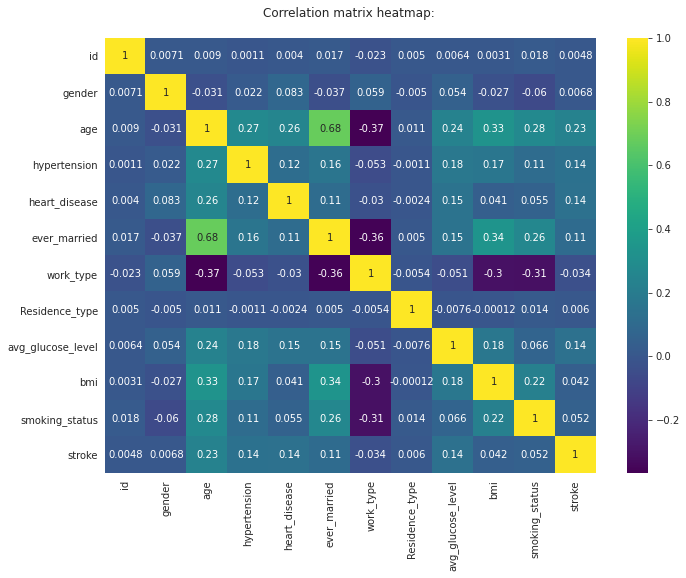

In [ ]:
# Correlation matrix heatmap 
plt.figure(figsize = (11, 8)) 
sns.heatmap(df.corr(), annot = True, cmap = "viridis")
plt.title("Correlation matrix heatmap: \n")
plt.show()

**Observation :**

* There is no distinguishable correlation between the given characteristics.

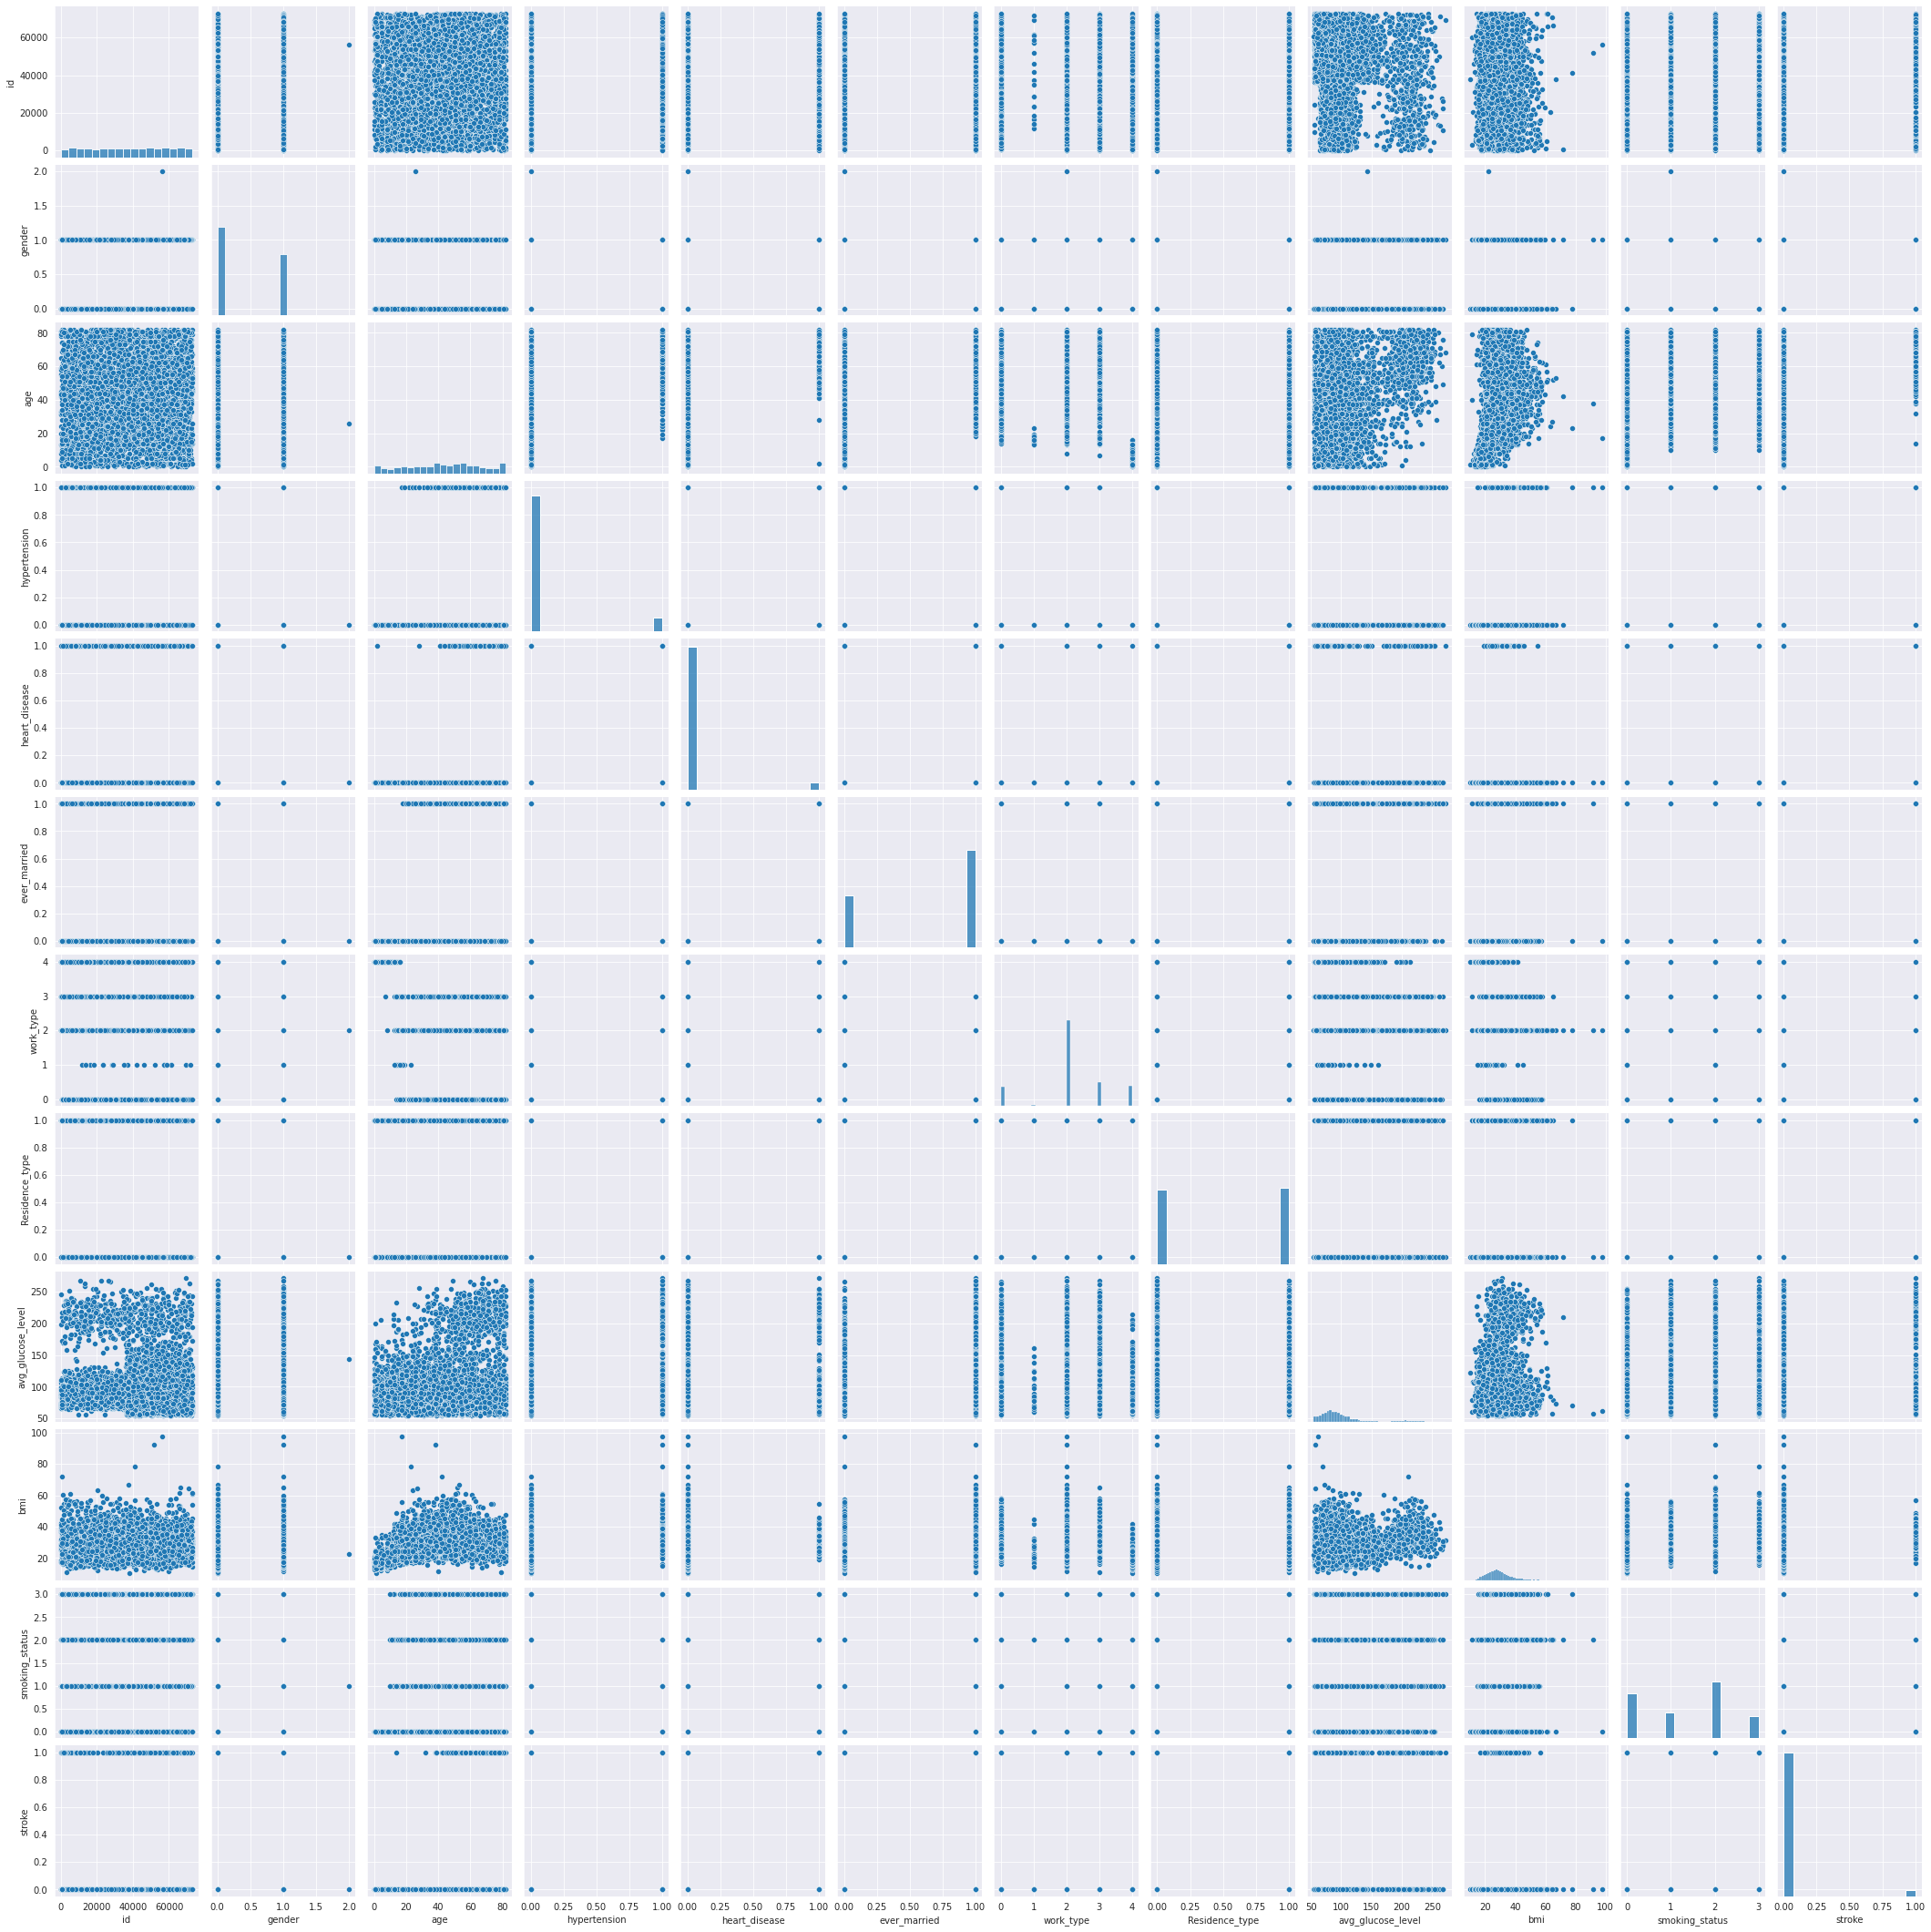

In [ ]:
# Pairplot
sns.pairplot(df)
plt.show()

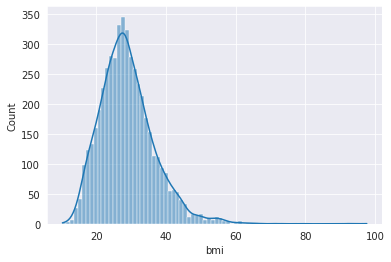

In [ ]:
sns.histplot(x = "bmi",kde = True,data = df)
plt.show()

**Remark :**

Despite the fact that the distributions of bmi and glucose level are distorted, we don't need to apply log transformation to them since we'll be using a decision trees classifier, which isn't affected by the scale of features.

In [ ]:
print("Percentage of smokers who had a stroke: ")
((df.groupby("smoking_status").sum().loc[:,"stroke"] / df["smoking_status"].value_counts())*100).iloc[:3]

Percentage of smokers who had a stroke: 


0    1.955496
1    6.810036
2    4.535637
dtype: float64

**Remarks :**

* Though we had large number of smokers in the dataset, it is suprising to see that highest percentage of people who had a stroke are non-smokers.

### Hypothesis Testing

Hypothesis testing is an important aspect of statistics and data analysis. Most of the time, it is virtually impossible to collect data from the entire population. In that case, we take a sample and estimate or make assumptions about the whole population. These conclusions or arguments are referred to as hypotheses. Hypothesis testing is the method of determining whether there is evidence to disprove a hypothesis.
Hypothesis testing normally is done on proportion and mean.

We are going to cover the hypothesis testing of the population proportion, the difference in population proportion, population or sample mean and the difference in the sample mean.

**Hypothesis testing for One proportion**

This is the most basic hypothesis testing. Most of the time we do not have a specific fixed value for comparison. But if we have, this is the most simple hypothesis testing.

In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1
5,56669,1,81.0,0,0,1,2,1,186.21,29.0,1,1


The last column of the dataset is ‘stroke’. That is if the person has a stroke or not.

The question we want to solve in this section is: “The population proportion of Ireland having stroke is 2%. Are more people suffering from stroke in the US”?

**Step 1 :** Define the null hypothesis and alternative hypothesis.

In this problem, the null hypothesis is the population proportion having stroke in the US is less than or equal to 2%. But if we test for equal to less than will be covered automatically. So, we are making it only equal to.

And the alternative hypothesis is the population proportion of the US having stroke is more than 2%

**Step 2 :** Assume that the dataset above is a representative sample from the population of the US. So, calculate the population proportion of the US having stroke.

In [ ]:
p_us = len(df[df['stroke']==1])/len(df)
print(p_us)

0.04257486249745366


**Step 3:** Calculate the Test Statistic:

*Here is the formula for test-statistics :* Best estimate - Hypothesized esstimate/standard error of estimate.(whole numerator divided by the standard error of estimate.)

Now calculate the standard error and the test statistics:

In [ ]:
se = np.sqrt(0.02 * (1-0.02) / len(df))
print(se)

0.0019981657916353394


Find the test statistics using the formula for test statistic above:

In [ ]:
#Best estimate
be = p_us  #hypothesized estimate
he = 0.02
test_stat = (be - he)/se
print(test_stat)

11.297792501481037


Calculate the p-value

This test statistic is also called z-score. we can find the p-value from a z_table or we can find the p-value from this formula in python.

In [ ]:
pvalue = 2*dist.norm.cdf(-np.abs(test_stat))
print(pvalue)

1.345579250138938e-29


**Step 5:** Infer the conclusion from the p-value

Consider the significance level alpha to be 5% or 0.05. A significance level of 5% or less means that there is a probability of 95% or greater that the results are not random.

Here p-value is smaller than our considered significance level 0.05. So, we can reject the null hypothesis. That means there is significant difference in population proportion having heart disease in Ireland and the US.

### Hypothesis Tests for the Difference in Two Proportions

Here, we are going to test if the population proportion of females with stroke is different from the population proportion of males with stroke.

**Step 1:** Set up the null hypothesis, alternative hypothesis, and significance level.

Here, we want to check if there is any difference between the population proportion of males and females having stroke. We will start with the assumption that there is no difference.

H0: p1 - p2 = 0

This is our null hypothesis. Here, p1 is the population proportion of females with stroke and p2 is the population proportion of males having stroke. Let’s use the significance level of 0.1 or 10%

**Step 2:** Prepare a chart that shows the population proportion of males and females with stroke and the total male and female population.

In [ ]:
df['Gender'] = df.gender.replace({1: "Male", 0: "Female"})
p = df.groupby("Gender")['stroke'].agg([lambda z: np.mean(z==1), "size"])
p.columns = ["Stroke", 'Total']
p

,Stroke,Total
Gender,,
2,0.000000,1
Female,0.041422,2897
Male,0.044257,2011


**Step 3:** Calculate the test statistic

We will use the same formula for the test statistic as before. The best estimate is p1 — p2. Here, p1 is the population proportion of females with heart disease and p2 is the population proportion of males with heart disease.

In [ ]:
#Best estimate is p1 - p2. Get p1 and p2 from the chart p above
p_fe = p.Stroke.Female
p_male = p.Stroke.Male

The standard error for two population proportion is calculated with the formula below:

![image.png](attachment:image.png)

Here, p is the total population proportion in the sample with stroke. n1 and n2 are the total numbers of the female and male populations in the sample.

In [ ]:
n1 = p.Total.Female
n2 = p.Total.Male
se = np.sqrt(p_us*(1-p_us)*(1/n1 + 1/n2))
print(se)

0.005860046120204206


Now, use this standard error and calculate the test statistic.

In [ ]:
# Calculate the best estimate
be = p_fe - p_male  #Calculate the hypothesized estimate
# Our null hypothesis is p1 - p2 = 0he = 0
# Calculate the test statistic
test_statistic = (be - he)/se
print(test_statistic)

-3.8966293843701596


**Step 4:** Calculate the p-value

In [ ]:
pvalue = 2*dist.norm.cdf(-np.abs(test_statistic))
print(pvalue)

9.754070868915835e-05


The p-value is smaller than the significance level (0.1). So, we do have enough evidence to reject the null hypothesis.

Hence the population proportion of males with stroke is significantly different than the population proportion of females with stroke.

### Hypothesis Testing for One Mean

The question we want to solve in this section is:

“Check if the mean avg_glucose_level is great than 200”. We have a trestbps column in the DataFrame. Let’s solve this problem step by step.

**Step 1:** State the hypothesis

We need to find out if the mean avg_glucose_level is greater than 200. Let’s assume that the mean avg_glucose_level is less than or equal to 200.

So, the null hypothesis can be that mean avg_glucose_level is 200. Because if we can prove that the mean avg_glucose_level is greater than 200, it is automatically greater than 200 or 195.

If we find enough evidence to reject the null hypothesis, we can accept that the mean avg_glucose_level is greater than 200. This is the alternative hypothesis for this example.

We will check if we can reject the null hypothesis using a significance level of 0.05.

**Step 2:** Check the two assumptions:
* The sample should be a simple random sample.
* The data need to be normally distributed.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


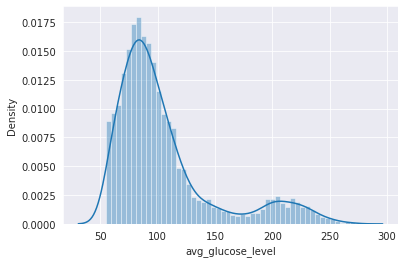

In [ ]:
import seaborn as sns
sns.distplot(df.avg_glucose_level)

The distribution is not exactly normal. But Usually for huge data set , the data is close to the normally distributed.

**Step 3:** Calculate the test statistic.

*Here is the formula to calculate the test statistic:* Best estimate - Hypothesized estimate / standard error of estimate.

First, calculate the standard error using the formula below:

SE = s / square root of n.

In [ ]:
std= df.avg_glucose_level.std()
n = len(df)
se = std/np.sqrt(n)
print(se)

0.6340514130328307


In [ ]:
#Best estimate
be = df.avg_glucose_level.mean() #Hypothesized estimatehe = 200
test_statistic = (be - he)/se
print(test_statistic)

166.05143930109494


**Step 4:** Infer the conclusion from the test statistic

Convert this test_statistic to a probability value to see if this difference is unusual or not. We can get the value using this python formula:

In [ ]:
pvalue = 2*dist.norm.cdf(-np.abs(test_statistic))
print(pvalue)

0.0


### Hypothesis Testing for the Difference in Mean

For this example, we will use the same data i.e. the avg_glucose_level column. But this time to test if there is any difference between the mean avg_glucose_level of females to the mean avg_glucose_level of males.

**Step 1:** State the hypothesis

As a null hypothesis, start with the claim that the mean avg_glucose_level of females and the mean avg_glucose_level of males are the same. So the difference between these two means will be zero.

The alternative hypothesis is, these two means are not the same. Let’s perform the test with a 10% significance level.

Ho: mu_female - mu_male = 0

Ha: mu_female - mu_male != 0

**Step 2:** Calculate the test statistic

The formula for the test statistic is the same as before. But the formula for the standard error is different.

SE = ((s1)2/n1 + (s2)2/n2)1/2

SE = Under root to the sum of s1 squared divided by n1 and s2 squared divided by n2

Here s1 and s2 are the sample standard deviation of the female and male population respectively. n1 and n2 are the sample size of the female and male population. Now, calculate the standard error:

In [ ]:
pop_fe = df[df.Gender=='Female'].dropna()
pop_male = df[df.Gender=='Male'].dropna()
std_fe = pop_fe.avg_glucose_level.std()
std_male = pop_male.avg_glucose_level.std()
se = np.sqrt(std_fe**2/len(pop_fe) + std_male**2/len(pop_male))
print(se)

1.3069994277030341


Use the standard error to get the test statistic.

In [ ]:
# Calculate the best estimate
mu_fe = pop_fe.avg_glucose_level.mean()     # Mean Ravg_glucose_level for females
mu_male = pop_male.avg_glucose_level.mean()  # Mean avg_glucose_level for malesmu_diff = mu_fe - mu_male    
# Hypothesized estimate 
mu_diff_hyp = 0   # Null hypothesis: difference of two mean = zero
test_statistic = (be-he)/se
print(test_statistic)

80.55485526112764


**Step 3:** Infer the conclusions from the test statistic

Calculate the p-value from this test statistic in python:

In [ ]:
pvalue = 2*dist.norm.cdf(-np.abs(test_statistic))
print(pvalue)

0.0


### Model training

In [ ]:
X = df.drop(["stroke","Gender"],axis=1)
y = df["stroke"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify = df["stroke"])
skf = StratifiedKFold(n_splits = 3,shuffle = True, random_state = 42)

In [ ]:
class Passthrough(BaseEstimator,TransformerMixin):
  def fit(self,X,y = None):
    return self
  def transform(self,X):
    return X

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

In [ ]:
steps = []
steps.append(("upsample",SMOTE()))
steps.append(("reduction",PCA()))
steps.append(("decision_tree",DecisionTreeClassifier()))
model = imblearn.pipeline.Pipeline(steps=steps)

In [ ]:
# Perform grid search on train data and returns the estimator with the best F-score

param_grid = [dict(upsample = [Passthrough(),SMOTE(random_state = 42)],\
                   reduction = [PCA(n_components = "mle"),LinearDiscriminantAnalysis()])]
              
grid_search = GridSearchCV(model,param_grid,\
                           scoring = ["f1_weighted",'neg_mean_absolute_error','neg_mean_squared_error','r2',"accuracy"]\
                           ,cv = skf,return_train_score = True,refit = "f1_weighted")

grid_search.fit(X_train,y_train)
cvres = grid_search.cv_results_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
# Here gridsearch has found that upsampling is not the best step to take, despite the heavily imbalanced nature of the dataset.
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('upsample', Passthrough()),
                ('reduction',
                 LinearDiscriminantAnalysis(n_components=None, priors=None,
                                            shrinkage=None, solver='svd',
                                            store_covariance=False,
                                            tol=0.0001)),
                ('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
 

In [ ]:
# Prints the best found hyperparameter setting during GridSearchCV and the error metrics associated with it

print(grid_search.best_params_)
index = grid_search.best_index_
print("\n")
test_f1, train_f1, test_mae, train_mae, test_mse, train_mse, test_r2, train_r2, test_acc, train_acc\
                                      = cvres["mean_test_f1_weighted"][index],cvres["mean_train_f1_weighted"][index]\
                                      ,cvres["mean_test_neg_mean_absolute_error"][index],cvres["mean_train_neg_mean_absolute_error"][index]\
                                      ,cvres["mean_test_neg_mean_squared_error"][index],cvres["mean_train_neg_mean_squared_error"][index]\
                                      ,cvres["mean_test_r2"][index],cvres["mean_train_r2"][index]\
                                      ,cvres["mean_test_accuracy"][index],cvres["mean_train_accuracy"][index]
  
print(f"Train Scores -> F1 score: {train_f1}, MAE :{-train_mae}, RMSE: {np.sqrt(-train_mse)}, R^2: {train_r2}, Accuracy: {train_acc} ;\n\
Validation Scores -> F1 score:{test_f1}, MAE:{-test_mae}, RMSE:{np.sqrt(-test_mse)}, R^2: {test_r2}, Accuracy: {test_acc} ")

{'reduction': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), 'upsample': Passthrough()}


Train Scores -> F1 score: 1.0, MAE :-0.0, RMSE: -0.0, R^2: 1.0, Accuracy: 1.0 ;
Validation Scores -> F1 score:0.9232260393626236, MAE:0.07486631016042782, RMSE:0.2736170867479365, R^2: -0.8394456388134718, Accuracy: 0.9251336898395722 


In [ ]:
# Prints the value of error metrics on each test hyperparameter setting in GridSearchCV

for test_f1, train_f1, test_mae, train_mae, test_mse, train_mse, test_r2, train_r2,test_acc,train_acc, params in\
                                      zip(cvres["mean_test_f1_weighted"],cvres["mean_train_f1_weighted"]\
                                      ,cvres["mean_test_neg_mean_absolute_error"],cvres["mean_train_neg_mean_absolute_error"]\
                                      ,cvres["mean_test_neg_mean_squared_error"],cvres["mean_train_neg_mean_squared_error"]\
                                      ,cvres["mean_test_r2"],cvres["mean_train_r2"]\
                                      ,cvres["mean_test_accuracy"],cvres["mean_train_accuracy"],cvres["params"]):
  
  print(params,"\n")

  print(f"Train Scores -> F1 score: {train_f1}, MAE :{-train_mae}, RMSE: {np.sqrt(-train_mse)}, R^2: {train_r2}, Accuracy: {train_acc} ;\n\
Validation Scores -> F1 score:{test_f1}, MAE:{-test_mae}, RMSE:{np.sqrt(-test_mse)}, R^2: {test_r2}, Accuracy: {test_acc} ")
  
  print("-"*170)

{'reduction': PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'upsample': Passthrough()} 

Train Scores -> F1 score: 1.0, MAE :-0.0, RMSE: -0.0, R^2: 1.0, Accuracy: 1.0 ;
Validation Scores -> F1 score:0.9218809511343647, MAE:0.08148714031066973, RMSE:0.285459524820367, R^2: -1.0013403026781444, Accuracy: 0.9185128596893303 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
{'reduction': PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'upsample': SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
      out_step='deprecated', random_state=42, ratio=None,
      sampling_strategy='auto', svm_estimator='deprecated')} 

Train Scores -> F1 score: 1.0, MAE :-0.0, RMSE: -0.0, R^2: 1.0, Accuracy: 1.0 ;


In [ ]:
# Best F-Score calculated during the hyperparameter search
grid_search.best_score_

0.9232260393626236

### Predicting on test data

--Decision Trees metrics--

Accuracy:  0.9215885947046843
Mean Absolute Error:  0.07841140529531568
Mean Square Error:  0.07841140529531568
R^2 Error:  -0.9152482269503546
Precision :  0.9258342044385699
Recall:  0.9215885947046843
Fscore on test dataset: 0.9236866137287658




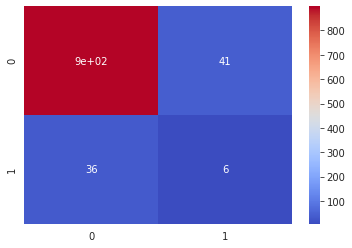

In [ ]:
# Test the model on test data
y_test_pred = grid_search.predict(X_test)
print("--Decision Trees metrics--\n")

precision,recall,fscore,_ = precision_recall_fscore_support(y_test,y_test_pred,average = "weighted")
print("Accuracy: ",accuracy_score(y_test,y_test_pred))
print("Mean Absolute Error: ", mean_absolute_error(y_test,y_test_pred))
print("Mean Square Error: ", mean_squared_error(y_test,y_test_pred))
print("R^2 Error: ", r2_score(y_test,y_test_pred))
print("Precision : ", precision)
print("Recall: ", recall)
print("Fscore on test dataset:", fscore)

print("\n")
sns.heatmap(confusion_matrix(y_test,y_test_pred),annot=True,cmap = "coolwarm")
plt.show()